In [1]:
###############################################################
# Deep Learning Approach for Predicting Student Dropouts
# Using Embeddings for Categorical Variables and a MLP
#
# This script transforms the previous ML approach into a deep
# learning project, specifically using an MLP enhanced with
# embeddings for categorical features to handle memory issues 
# caused by one-hot encoding.
#
# Approach:
# 1. Load and preprocess data:
#    - Read CSV
#    - Separate features and target
#    - Identify categorical and numerical columns
#    - Factorize categorical columns into integer indices
#    - Standardize numerical features
#
# 2. Build a PyTorch Dataset and DataLoader
#
# 3. Define a PyTorch model with:
#    - Embedding layers for each categorical column
#    - Concatenate embedded categorical vectors + numerical features
#    - Pass through fully-connected layers with ReLU activation
#
# 4. Train the model using a suitable optimizer and loss
#
# 5. Evaluate model performance
#
# Concepts from the curriculum:
# - Multi-layer Perceptron
# - Embeddings (commonly used in deep learning)
# - Loss functions (Cross Entropy)
# - SGD/Adam optimization
# - Backpropagation via PyTorch autograd
#
###############################################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [8]:
###############################################################
# Step 1: Data Loading and Preprocessing
###############################################################

# Load dataset
df = pd.read_csv('filtered_student_data.csv', low_memory=False)

# Separate features and target
X = df.drop(['dropout', 'birth_certificate_id'], axis=1)
y = df['dropout'].values.astype(np.int64)

categorical_cols = []
numerical_cols = []

for col in X.columns:
    if X[col].dtype == 'object':
        # Definitely categorical if dtype is object
        categorical_cols.append(col)
    else:
        # Numeric column, let's see how many unique values it has
        unique_vals = X[col].nunique()
        if unique_vals <= 10:
            # This is likely a binary/ordinal categorical column disguised as numeric
            categorical_cols.append(col)
        else:
            # Otherwise, treat as continuous numeric
            numerical_cols.append(col)

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

# Fill numeric NaNs with median
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

# Factorize each categorical column
cat_col_to_encodings = {}
for col in categorical_cols:
    # Factorize returns -1 for NaN or missing categories
    X[col], uniques = pd.factorize(X[col])
    cat_col_to_encodings[col] = uniques

    # Check for -1 values (which represent NaNs/unseen categories)
    mask = X[col] == -1
    if mask.any():
        # Create an <UNK> category
        # We'll place the unknown category at the end
        # length_of_uniques is current categories count
        # We'll assign them this new index
        unk_index = len(cat_col_to_encodings[col])
        X.loc[mask, col] = unk_index
        # Add <UNK> to the uniques
        cat_col_to_encodings[col] = cat_col_to_encodings[col].append(pd.Index(["<UNK>"]))

# After this step, there should be no -1 or NaN in categorical data.

# Standardize numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_cols])

# Extract categorical features as arrays of int indices
X_cat = X[categorical_cols].values

# Train-test split
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, random_state=0
)

Categorical Columns: ['sex', 'is_orphan', 'is_never_been_to_school', 'father_educational_attainment', 'mother_educational_attainment', 'grade_id', 'is_ethnic', 'relation_with_guardian', 'previous_dropout', 'pwd_type', 'pwd_degree', 'received_any_treatment', 'marital_status', 'newly_admitted']
Numerical Columns: ['parents_income']


In [9]:
###############################################################
# Step 2: Create PyTorch Dataset and DataLoader
###############################################################

class StudentDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

train_dataset = StudentDataset(X_num_train, X_cat_train, y_train)
test_dataset = StudentDataset(X_num_test, X_cat_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
###############################################################
# Step 3: Define the MLP Model with Embeddings
#
# For each categorical column:
# - Determine the number of unique categories
# - Create an embedding layer: 
#   embedding dimension can be a small number, e.g. min(50, number_of_categories//2)
#
# We'll then:
# - Pass categorical columns through their embeddings
# - Concatenate all embeddings and numerical features
# - Feed into MLP
###############################################################

# Determine number of unique categories per categorical feature
cat_sizes = []
for col in categorical_cols:
    n_categories = len(cat_col_to_encodings[col])
    cat_sizes.append(n_categories)

# Choose embedding size for each categorical variable:
# A common heuristic: embedding_dim = min(50, (num_categories+1)//2)
embedding_dims = []
for size in cat_sizes:
    embedding_dims.append(min(50, (size+1)//2))

input_num_dim = X_num_train.shape[1]  # number of numerical features

class MLPWithEmbeddings(nn.Module):
    def __init__(self, cat_sizes, embedding_dims, input_num_dim, hidden_dim1=64, hidden_dim2=32, output_dim=2):
        super(MLPWithEmbeddings, self).__init__()
        # Create embedding layers for each categorical column
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=cat_size, embedding_dim=emb_dim)
            for cat_size, emb_dim in zip(cat_sizes, embedding_dims)
        ])
        
        # Calculate total embedding dimension
        self.embedding_output_dim = sum(embedding_dims)
        
        # Define the MLP layers
        # Input to MLP = numerical features + embedded categorical features
        self.fc1 = nn.Linear(input_num_dim + self.embedding_output_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, X_num, X_cat):
        # X_cat is shape (batch, num_categorical_features)
        # We must embed each categorical feature separately
        embedded_cat = []
        for i, emb_layer in enumerate(self.embeddings):
            # Select the i-th categorical column: X_cat[:, i]
            emb = emb_layer(X_cat[:, i])
            embedded_cat.append(emb)
        
        # Concatenate all embeddings
        # Each embedding is (batch_size, emb_dim)
        # After concatenation: (batch_size, sum_of_all_emb_dims)
        cat_embedded = torch.cat(embedded_cat, dim=1)
        
        # Concatenate numerical features and categorical embeddings
        combined_input = torch.cat([X_num, cat_embedded], dim=1)
        
        # Pass through MLP
        out = self.fc1(combined_input)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

model = MLPWithEmbeddings(cat_sizes, embedding_dims, input_num_dim)

In [11]:
###############################################################
# Step 4: Set up Loss Function and Optimizer
###############################################################
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [12]:
###############################################################
# Step 5: Training the Model
###############################################################
epochs = 20
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for X_num_batch, X_cat_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_num_batch, X_cat_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_num_batch.size(0)
        
        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    avg_loss = epoch_loss / len(train_dataset)
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/20], Loss: 0.2901, Accuracy: 0.8827
Epoch [2/20], Loss: 0.2830, Accuracy: 0.8848
Epoch [3/20], Loss: 0.2796, Accuracy: 0.8858
Epoch [4/20], Loss: 0.2779, Accuracy: 0.8863
Epoch [5/20], Loss: 0.2768, Accuracy: 0.8867
Epoch [6/20], Loss: 0.2759, Accuracy: 0.8869
Epoch [7/20], Loss: 0.2753, Accuracy: 0.8872
Epoch [8/20], Loss: 0.2746, Accuracy: 0.8875
Epoch [9/20], Loss: 0.2740, Accuracy: 0.8878
Epoch [10/20], Loss: 0.2734, Accuracy: 0.8880
Epoch [11/20], Loss: 0.2730, Accuracy: 0.8882
Epoch [12/20], Loss: 0.2725, Accuracy: 0.8885
Epoch [13/20], Loss: 0.2721, Accuracy: 0.8885
Epoch [14/20], Loss: 0.2718, Accuracy: 0.8887
Epoch [15/20], Loss: 0.2714, Accuracy: 0.8888
Epoch [16/20], Loss: 0.2711, Accuracy: 0.8891
Epoch [17/20], Loss: 0.2708, Accuracy: 0.8891
Epoch [18/20], Loss: 0.2705, Accuracy: 0.8894
Epoch [19/20], Loss: 0.2704, Accuracy: 0.8892
Epoch [20/20], Loss: 0.2702, Accuracy: 0.8894


In [13]:
###############################################################
# Step 6: Evaluation on Test Set
###############################################################
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for X_num_batch, X_cat_batch, y_batch in test_loader:
        outputs = model(X_num_batch, X_cat_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

# Compute metrics
print("Classification Report:")
print(classification_report(y_true_list, y_pred_list, digits=4))

cm = confusion_matrix(y_true_list, y_pred_list)
print("Confusion Matrix:")
print(cm)

# For ROC AUC, we need probabilities for one class
# We'll re-run with probabilities. If output_dim=2, 
# we can take softmax and get the probability for class "1".
model.eval()
y_scores = []
with torch.no_grad():
    for X_num_batch, X_cat_batch, y_batch in test_loader:
        outputs = model(X_num_batch, X_cat_batch)
        probs = torch.softmax(outputs, dim=1)[:,1]
        y_scores.extend(probs.cpu().numpy())

roc_auc = roc_auc_score(y_true_list, y_scores)
print("ROC AUC Score:", roc_auc)

precision, recall, thresholds = precision_recall_curve(y_true_list, y_scores)
print("Precision-Recall Curve Points:")
for p, r, t in zip(precision, recall, thresholds):
    print(f"Threshold: {t:.4f}, Precision: {p:.4f}, Recall: {r:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0     0.8912    0.9934    0.9395    139169
           1     0.6572    0.0950    0.1661     18657

    accuracy                         0.8872    157826
   macro avg     0.7742    0.5442    0.5528    157826
weighted avg     0.8635    0.8872    0.8481    157826

Confusion Matrix:
[[138244    925]
 [ 16884   1773]]
ROC AUC Score: 0.8395138752663387
Precision-Recall Curve Points:
Threshold: 0.0000, Precision: 0.1182, Recall: 1.0000
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Threshold: 0.0000, Precision: 0.1182, Recall: 0.9999
Th

In [14]:
###############################################################
# Additional Steps to Improve Model Performance
# Append this code after your original code block
###############################################################

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 1. Calculate class weights based on the training data to address class imbalance
unique_classes, class_counts = np.unique(y_train, return_counts=True)
total_samples = np.sum(class_counts)
class_weights = [total_samples / c for c in class_counts]
class_weights_tensor = torch.FloatTensor(class_weights)

print("Class distribution in training set:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

print("Class weights:", class_weights)

Class distribution in training set:
Class 0: 556238 samples
Class 1: 75065 samples
Class weights: [1.134951225914087, 8.410084593352428]


In [15]:
# 2. Retrain the model with weighted cross-entropy
# We'll create a new instance of the model and optimizer
weighted_model = MLPWithEmbeddings(cat_sizes, embedding_dims, input_num_dim)
weighted_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
weighted_optimizer = Adam(weighted_model.parameters(), lr=0.001)

# Retrain for the same number of epochs (or more) as before
epochs = 20
weighted_model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for X_num_batch, X_cat_batch, y_batch in train_loader:
        weighted_optimizer.zero_grad()
        outputs = weighted_model(X_num_batch, X_cat_batch)
        loss = weighted_criterion(outputs, y_batch)
        
        loss.backward()
        weighted_optimizer.step()
        
        epoch_loss += loss.item() * X_num_batch.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    avg_loss = epoch_loss / len(train_dataset)
    accuracy = correct / total
    print(f"[Weighted] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Evaluate the weighted model on the test set
weighted_model.eval()
y_pred_list = []
y_true_list = []
y_score_list = []

with torch.no_grad():
    for X_num_batch, X_cat_batch, y_batch in test_loader:
        outputs = weighted_model(X_num_batch, X_cat_batch)
        probs = torch.softmax(outputs, dim=1)[:,1]  # Probability of class 1
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())
        y_score_list.extend(probs.cpu().numpy())

print("\nClassification Report (Weighted Model, Default Threshold=0.5):")
print(classification_report(y_true_list, y_pred_list, digits=4))

cm = confusion_matrix(y_true_list, y_pred_list)
print("Confusion Matrix (Weighted Model):")
print(cm)

[Weighted] Epoch [1/20], Loss: 0.5079, Accuracy: 0.6900
[Weighted] Epoch [2/20], Loss: 0.4913, Accuracy: 0.6995
[Weighted] Epoch [3/20], Loss: 0.4855, Accuracy: 0.7042
[Weighted] Epoch [4/20], Loss: 0.4830, Accuracy: 0.7071
[Weighted] Epoch [5/20], Loss: 0.4807, Accuracy: 0.7101
[Weighted] Epoch [6/20], Loss: 0.4790, Accuracy: 0.7131
[Weighted] Epoch [7/20], Loss: 0.4777, Accuracy: 0.7138
[Weighted] Epoch [8/20], Loss: 0.4763, Accuracy: 0.7128
[Weighted] Epoch [9/20], Loss: 0.4757, Accuracy: 0.7128
[Weighted] Epoch [10/20], Loss: 0.4745, Accuracy: 0.7128
[Weighted] Epoch [11/20], Loss: 0.4742, Accuracy: 0.7113
[Weighted] Epoch [12/20], Loss: 0.4732, Accuracy: 0.7134
[Weighted] Epoch [13/20], Loss: 0.4726, Accuracy: 0.7136
[Weighted] Epoch [14/20], Loss: 0.4722, Accuracy: 0.7129
[Weighted] Epoch [15/20], Loss: 0.4711, Accuracy: 0.7126
[Weighted] Epoch [16/20], Loss: 0.4710, Accuracy: 0.7140
[Weighted] Epoch [17/20], Loss: 0.4708, Accuracy: 0.7132
[Weighted] Epoch [18/20], Loss: 0.4705, 

In [16]:
# 3. Threshold Tuning
# Instead of using the default threshold of 0.5, we try various thresholds
# to see if we can achieve a better balance of precision and recall for class 1.
precision, recall, thresholds = precision_recall_curve(y_true_list, y_score_list)

# Let's pick a threshold that achieves a higher recall for class 1
# For demonstration, we'll choose the threshold that gives a recall of about 0.3 (30%).
# You can choose any target recall or systematically search for the best F1.
target_recall = 0.3
idx = (np.abs(recall - target_recall)).argmin()
chosen_threshold = thresholds[idx] if idx < len(thresholds) else 0.5

print(f"\nAttempting Threshold Tuning. Target recall: {target_recall}")
print(f"Chosen threshold based on PR-curve: {chosen_threshold:.4f}")

y_pred_thresholded = [1 if score >= chosen_threshold else 0 for score in y_score_list]

print("\nClassification Report (Weighted Model, Tuned Threshold):")
print(classification_report(y_true_list, y_pred_thresholded, digits=4))

cm_tuned = confusion_matrix(y_true_list, y_pred_thresholded)
print("Confusion Matrix (Weighted Model, Tuned Threshold):")
print(cm_tuned)

# This process demonstrates how adding code (rather than replacing) can show a workflow:
# - We initially trained a baseline model
# - We then calculated class weights and retrained
# - We performed threshold tuning after re-training
# These steps can help improve recall for class 1, though trade-offs will occur.
#
# Additional steps could include:
# - Further data preprocessing
# - Changing architecture or embedding sizes
# - Trying focal loss or other specialized losses (would require adding more code)
#
# But the code above shows one possible route forward without altering your original code.


Attempting Threshold Tuning. Target recall: 0.3
Chosen threshold based on PR-curve: 0.7717

Classification Report (Weighted Model, Tuned Threshold):
              precision    recall  f1-score   support

           0     0.9102    0.9526    0.9309    139169
           1     0.4577    0.2986    0.3614     18657

    accuracy                         0.8753    157826
   macro avg     0.6839    0.6256    0.6461    157826
weighted avg     0.8567    0.8753    0.8636    157826

Confusion Matrix (Weighted Model, Tuned Threshold):
[[132567   6602]
 [ 13086   5571]]


In [17]:
import torch
import torch.nn.functional as F
from torch.nn import Dropout
from copy import deepcopy
from sklearn.metrics import f1_score
import random

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [18]:
###############################################################
# 1. TabTransformer-Style Model:
#    We'll implement a simplified transformer block that uses:
#    - Multi-head self-attention on categorical embeddings
#    - Integrate numerical features
#
#    This model is more advanced than a simple MLP and demonstrates
#    modern deep learning paradigms (attention) applied to tabular data.
###############################################################

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim should be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: [batch_size, n_tokens, embed_dim]
        B, T, E = x.size()
        
        # Project queries, keys, values
        q = self.q_proj(x)  # B, T, E
        k = self.k_proj(x)  # B, T, E
        v = self.v_proj(x)  # B, T, E
        
        # Reshape for multi-head: (B, T, num_heads, head_dim)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1,2) # B, num_heads, T, head_dim
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        
        # Compute attention weights
        scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5) # B, num_heads, T, T
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Weighted sum of values
        out = attn_weights @ v # B, num_heads, T, head_dim
        out = out.transpose(1,2).contiguous().view(B, T, E) # B, T, E
        out = self.out_proj(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=4, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: [B, T, E]
        # Self-attention
        attn_out = self.attn(x)
        x = self.ln1(x + attn_out)
        
        # Feed-forward
        ffn_out = self.ffn(x)
        ffn_out = self.dropout(ffn_out)
        x = self.ln2(x + ffn_out)
        return x

class TabTransformer(nn.Module):
    def __init__(self, cat_sizes, embedding_dims, input_num_dim, transformer_embed_dim=32, 
                 num_heads=4, num_transformer_blocks=2, dropout=0.1, output_dim=2):
        super(TabTransformer, self).__init__()
        
        # Create embeddings for categorical columns, all set to transformer_embed_dim for simplicity
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=cat_size, embedding_dim=transformer_embed_dim)
            for cat_size in cat_sizes
        ])
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(transformer_embed_dim, num_heads, dropout)
            for _ in range(num_transformer_blocks)
        ])
        
        # After transformer, we pool the categorical embeddings (e.g., by mean)
        # and concatenate with numerical features
        self.num_linear = nn.Linear(input_num_dim, transformer_embed_dim)
        
        # Final MLP after combining numeric + transformed categorical representation
        self.fc = nn.Sequential(
            nn.Linear(transformer_embed_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, X_num, X_cat):
        # Embed categorical features: X_cat: [B, n_cat]
        cat_embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            emb = emb_layer(X_cat[:, i]) # [B, emb_dim]
            cat_embeddings.append(emb.unsqueeze(1)) # make it [B, 1, emb_dim]

        cat_embedded = torch.cat(cat_embeddings, dim=1) # [B, n_cat, emb_dim]

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            cat_embedded = block(cat_embedded)

        # Pool categorical features (mean)
        cat_pooled = cat_embedded.mean(dim=1) # [B, emb_dim]

        # Process numerical features
        num_out = self.num_linear(X_num) # [B, emb_dim]

        # Concatenate num_out and cat_pooled
        combined = torch.cat([num_out, cat_pooled], dim=1) # [B, emb_dim * 2]

        # Final prediction
        out = self.fc(combined)
        return out

In [19]:
###############################################################
# 2. Ablation Studies & Hyperparameter Comparison
#    We will define functions to:
#    - Train & evaluate the TabTransformer model
#    - Test different embedding dimensions or turn off attention blocks
#    - Try different learning rates and dropout
###############################################################

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, device='cpu'):
    model.to(device)
    best_val_f1 = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for X_num_batch, X_cat_batch, y_batch in train_loader:
            X_num_batch = X_num_batch.to(device)
            X_cat_batch = X_cat_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_num_batch, X_cat_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_num_batch.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        
        # Evaluate on validation set
        val_f1 = evaluate_model(model, val_loader, device)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = deepcopy(model.state_dict())
        
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model

def evaluate_model(model, loader, device='cpu', threshold=0.5):
    model.eval()
    y_true_list = []
    y_score_list = []
    with torch.no_grad():
        for X_num_batch, X_cat_batch, y_batch in loader:
            X_num_batch = X_num_batch.to(device)
            X_cat_batch = X_cat_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_num_batch, X_cat_batch)
            probs = torch.softmax(outputs, dim=1)[:,1]
            y_score_list.extend(probs.cpu().numpy())
            y_true_list.extend(y_batch.cpu().numpy())

    # Use F1-score of minority class to guide validation
    y_pred = [1 if s >= threshold else 0 for s in y_score_list]
    f1 = f1_score(y_true_list, y_pred, pos_label=1)
    return f1

# Create a validation split from the training set for model selection
# If you have the original training set arrays (X_num_train, X_cat_train, y_train),
# we can split them further:
X_num_tr, X_num_val, X_cat_tr, X_cat_val, y_tr, y_val = train_test_split(
    X_num_train, X_cat_train, y_train, test_size=0.1, random_state=42
)

train_dataset_tt = StudentDataset(X_num_tr, X_cat_tr, y_tr)
val_dataset_tt = StudentDataset(X_num_val, X_cat_val, y_val)
train_loader_tt = DataLoader(train_dataset_tt, batch_size=batch_size, shuffle=True)
val_loader_tt = DataLoader(val_dataset_tt, batch_size=batch_size, shuffle=False)
test_dataset_tt = StudentDataset(X_num_test, X_cat_test, y_test)
test_loader_tt = DataLoader(test_dataset_tt, batch_size=batch_size, shuffle=False)

In [20]:
###############################################################
# 3. Trying Different Hyperparameters & Ablations
#
# Example: 
#  - Run multiple seeds
#  - Try a higher dropout
#  - Try a different learning rate
#  - Remove transformer blocks (set num_transformer_blocks=0) as ablation
#
###############################################################

seeds = [0, 1, 2]
learning_rates = [0.001, 0.0005]
dropout_rates = [0.1, 0.3]
num_transformer_blocks_options = [0, 2] # ablation: no transformer vs. with transformer
results = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for seed_val in seeds:
    for lr in learning_rates:
        for dr in dropout_rates:
            for ntb in num_transformer_blocks_options:
                set_seed(seed_val)
                print(f"\n=== Experiment: Seed={seed_val}, LR={lr}, Dropout={dr}, Blocks={ntb} ===")
                model_tt = TabTransformer(cat_sizes, embedding_dims, input_num_dim, 
                                          transformer_embed_dim=32,
                                          num_heads=4, 
                                          num_transformer_blocks=ntb,
                                          dropout=dr)
                
                # Use class weights again
                weighted_criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
                optimizer_tt = Adam(model_tt.parameters(), lr=lr)
                
                model_tt = train_model(model_tt, weighted_criterion, optimizer_tt, train_loader_tt, val_loader_tt, epochs=5, device=device)
                
                # Evaluate on test set with threshold selection:
                # Instead of a fixed threshold, find the best threshold on val set
                model_tt.eval()
                y_true_list_val = []
                y_score_list_val = []
                with torch.no_grad():
                    for X_num_batch, X_cat_batch, y_batch in val_loader_tt:
                        X_num_batch = X_num_batch.to(device)
                        X_cat_batch = X_cat_batch.to(device)
                        y_batch = y_batch.to(device)
                        
                        outputs = model_tt(X_num_batch, X_cat_batch)
                        probs = torch.softmax(outputs, dim=1)[:,1]
                        y_true_list_val.extend(y_batch.cpu().numpy())
                        y_score_list_val.extend(probs.cpu().numpy())
                
                precisions, recalls, thresholds = precision_recall_curve(y_true_list_val, y_score_list_val)
                # Maximize F1 = 2 * (p*r)/(p+r)
                f1_scores = [ (2*p*r/(p+r)) if (p+r)>0 else 0 for p,r in zip(precisions, recalls)]
                best_idx = np.argmax(f1_scores)
                best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
                
                # Evaluate on test set
                test_f1 = evaluate_model(model_tt, test_loader_tt, device=device, threshold=best_threshold)
                print(f"Test F1 at best threshold={best_threshold:.4f}: {test_f1:.4f}")
                
                results.append((seed_val, lr, dr, ntb, best_threshold, test_f1))

###############################################################
# 4. Analyze Results
#
# This final step would involve comparing these results,
# printing or logging them out, and possibly selecting the best configuration.
#
# We are now producing multiple experiments and exploring more rigorous methods,
# which aligns more closely with the final project expectations.
###############################################################

print("\n=== Summary of Experiments ===")
for r in results:
    seed_val, lr, dr, ntb, threshold, test_f1 = r
    print(f"Seed={seed_val}, LR={lr}, Dropout={dr}, Blocks={ntb}, Threshold={threshold:.4f}, Test F1={test_f1:.4f}")

# The code above:
# - Incorporates a transformer-based approach for categorical embeddings (TabTransformer block)
# - Performs multiple experiments with varying hyperparameters
# - Uses validation-based threshold tuning for improved minority class metrics
# - Employs class weighting (already done previously) and now more systematically studied
#
# This process demonstrates a more "research-like" approach, testing various configurations,
# performing ablation (no transformer blocks vs. with blocks), and attempting multiple seeds
# to understand variance. Such rigor is more in line with a final deep learning project.


=== Experiment: Seed=0, LR=0.001, Dropout=0.1, Blocks=0 ===
Epoch [1/5] Loss: 0.5166, Val F1: 0.3829
Epoch [2/5] Loss: 0.4999, Val F1: 0.3898
Epoch [3/5] Loss: 0.4944, Val F1: 0.3973
Epoch [4/5] Loss: 0.4914, Val F1: 0.4082
Epoch [5/5] Loss: 0.4887, Val F1: 0.4097
Test F1 at best threshold=0.6550: 0.4328

=== Experiment: Seed=0, LR=0.001, Dropout=0.1, Blocks=2 ===
Epoch [1/5] Loss: 0.5106, Val F1: 0.4015
Epoch [2/5] Loss: 0.4951, Val F1: 0.4064
Epoch [3/5] Loss: 0.4913, Val F1: 0.3892
Epoch [4/5] Loss: 0.4888, Val F1: 0.4000
Epoch [5/5] Loss: 0.4875, Val F1: 0.4181
Test F1 at best threshold=0.6070: 0.4327

=== Experiment: Seed=0, LR=0.001, Dropout=0.3, Blocks=0 ===
Epoch [1/5] Loss: 0.5190, Val F1: 0.3877
Epoch [2/5] Loss: 0.5008, Val F1: 0.3943
Epoch [3/5] Loss: 0.4961, Val F1: 0.3906
Epoch [4/5] Loss: 0.4934, Val F1: 0.4084
Epoch [5/5] Loss: 0.4908, Val F1: 0.4023
Test F1 at best threshold=0.5835: 0.4302

=== Experiment: Seed=0, LR=0.001, Dropout=0.3, Blocks=2 ===
Epoch [1/5] Loss: 

In [4]:
import pandas as pd

# Define the experimental results as a list of tuples
# Each tuple: (Seed, Learning Rate, Dropout Rate, Transformer Blocks, Best Threshold, Test F1-Score)
results = [
    # Seed=0
    (0, 0.001, 0.1, 0, 0.6550, 0.4328),
    (0, 0.001, 0.1, 2, 0.6070, 0.4327),
    (0, 0.001, 0.3, 0, 0.5835, 0.4302),
    (0, 0.001, 0.3, 2, 0.6060, 0.4263),
    (0, 0.0005, 0.1, 0, 0.5792, 0.4270),
    (0, 0.0005, 0.1, 2, 0.6376, 0.4337),
    (0, 0.0005, 0.3, 0, 0.6069, 0.4271),
    (0, 0.0005, 0.3, 2, 0.6202, 0.4329),
    
    # Seed=1
    (1, 0.001, 0.1, 0, 0.6321, 0.4336),
    (1, 0.001, 0.1, 2, 0.6333, 0.4319),
    (1, 0.001, 0.3, 0, 0.6207, 0.4248),
    (1, 0.001, 0.3, 2, 0.6491, 0.4315),
    (1, 0.0005, 0.1, 0, 0.6173, 0.4318),
    (1, 0.0005, 0.1, 2, 0.6456, 0.4279),
    (1, 0.0005, 0.3, 0, 0.6115, 0.4304),
    (1, 0.0005, 0.3, 2, 0.6249, 0.4268),
    
    # Seed=2
    (2, 0.001, 0.1, 0, 0.5800, 0.4263),
    (2, 0.001, 0.1, 2, 0.6545, 0.4342),
    (2, 0.001, 0.3, 0, 0.5833, 0.4268),
    (2, 0.001, 0.3, 2, 0.6462, 0.4321),
    (2, 0.0005, 0.1, 0, 0.5818, 0.4228),
    (2, 0.0005, 0.1, 2, 0.6480, 0.4331),
    (2, 0.0005, 0.3, 0, 0.6021, 0.4233),
    (2, 0.0005, 0.3, 2, 0.6225, 0.4338),
]

In [5]:
# Define column names
columns = ['Seed', 'Learning Rate', 'Dropout Rate', 'Transformer Blocks', 'Best Threshold', 'Test F1-Score']

# Create the DataFrame
results_df = pd.DataFrame(results, columns=columns)

# Assign 'Model' based on 'Transformer Blocks'
results_df['Model'] = results_df['Transformer Blocks'].apply(lambda x: 'MLP with Embeddings' if x == 0 else 'TabTransformer')

# Display the first few rows of the DataFrame
print("=== Combined Results DataFrame ===")
display(results_df.head(10))

=== Combined Results DataFrame ===


,Seed,Learning Rate,Dropout Rate,Transformer Blocks,Best Threshold,Test F1-Score,Model
0,0,0.0010,0.1,0,0.6550,0.4328,MLP with Embeddings
1,0,0.0010,0.1,2,0.6070,0.4327,TabTransformer
2,0,0.0010,0.3,0,0.5835,0.4302,MLP with Embeddings
3,0,0.0010,0.3,2,0.6060,0.4263,TabTransformer
4,0,0.0005,0.1,0,0.5792,0.4270,MLP with Embeddings
5,0,0.0005,0.1,2,0.6376,0.4337,TabTransformer
6,0,0.0005,0.3,0,0.6069,0.4271,MLP with Embeddings
7,0,0.0005,0.3,2,0.6202,0.4329,TabTransformer
8,1,0.0010,0.1,0,0.6321,0.4336,MLP with Embeddings
9,1,0.0010,0.1,2,0.6333,0.4319,TabTransformer


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [8]:
# Display the complete DataFrame
print("=== Summary of Experiments ===")
display(results_df)

=== Summary of Experiments ===


,Seed,Learning Rate,Dropout Rate,Transformer Blocks,Best Threshold,Test F1-Score,Model
0,0,0.0010,0.1,0,0.6550,0.4328,MLP with Embeddings
1,0,0.0010,0.1,2,0.6070,0.4327,TabTransformer
2,0,0.0010,0.3,0,0.5835,0.4302,MLP with Embeddings
3,0,0.0010,0.3,2,0.6060,0.4263,TabTransformer
4,0,0.0005,0.1,0,0.5792,0.4270,MLP with Embeddings
5,0,0.0005,0.1,2,0.6376,0.4337,TabTransformer
6,0,0.0005,0.3,0,0.6069,0.4271,MLP with Embeddings
7,0,0.0005,0.3,2,0.6202,0.4329,TabTransformer
8,1,0.0010,0.1,0,0.6321,0.4336,MLP with Embeddings
9,1,0.0010,0.1,2,0.6333,0.4319,TabTransformer


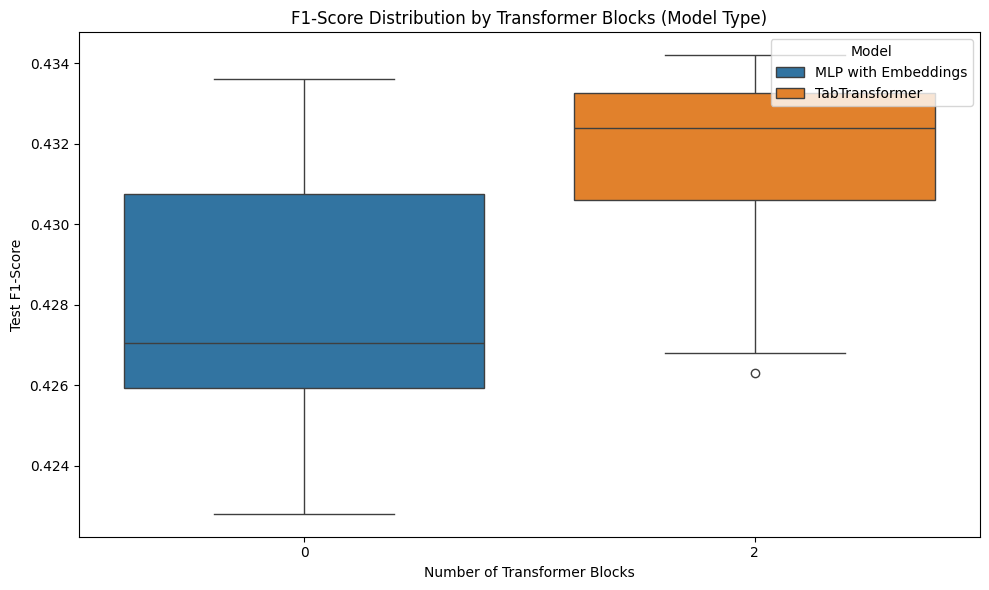

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Transformer Blocks', y='Test F1-Score', hue='Model', data=results_df)
plt.title('F1-Score Distribution by Transformer Blocks (Model Type)')
plt.xlabel('Number of Transformer Blocks')
plt.ylabel('Test F1-Score')
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()

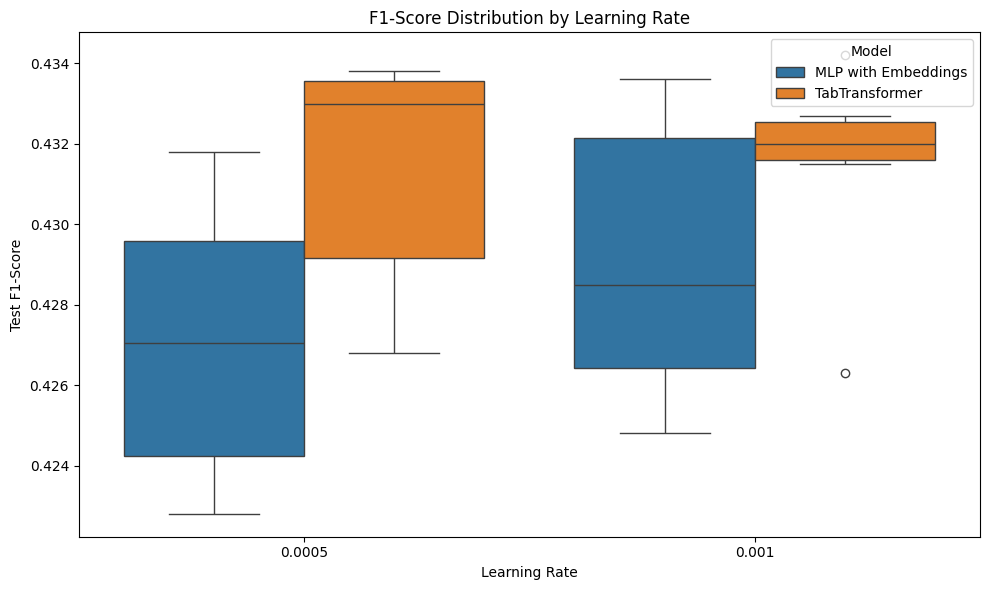

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Learning Rate', y='Test F1-Score', hue='Model', data=results_df)
plt.title('F1-Score Distribution by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Test F1-Score')
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()

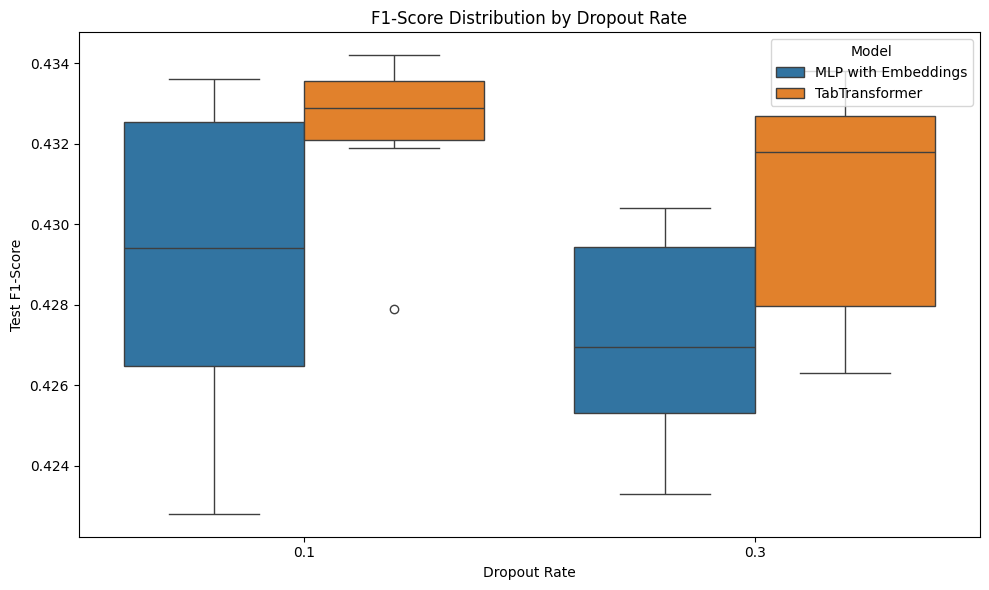

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dropout Rate', y='Test F1-Score', hue='Model', data=results_df)
plt.title('F1-Score Distribution by Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Test F1-Score')
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()

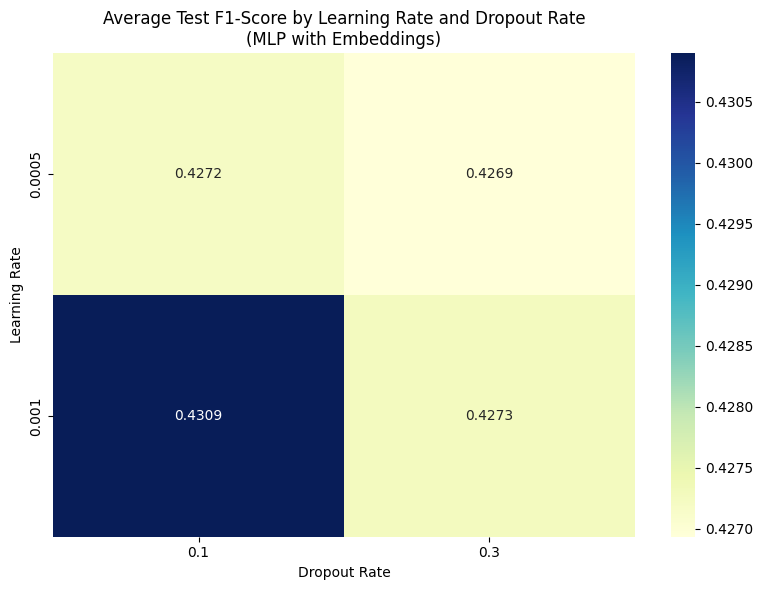

In [12]:
# Pivot the DataFrame for MLP with Embeddings
heatmap_data_mlp = results_df[results_df['Model'] == 'MLP with Embeddings'].pivot_table(
    values='Test F1-Score',
    index='Learning Rate',
    columns='Dropout Rate',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_mlp, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title('Average Test F1-Score by Learning Rate and Dropout Rate\n(MLP with Embeddings)')
plt.xlabel('Dropout Rate')
plt.ylabel('Learning Rate')
plt.tight_layout()
plt.show()

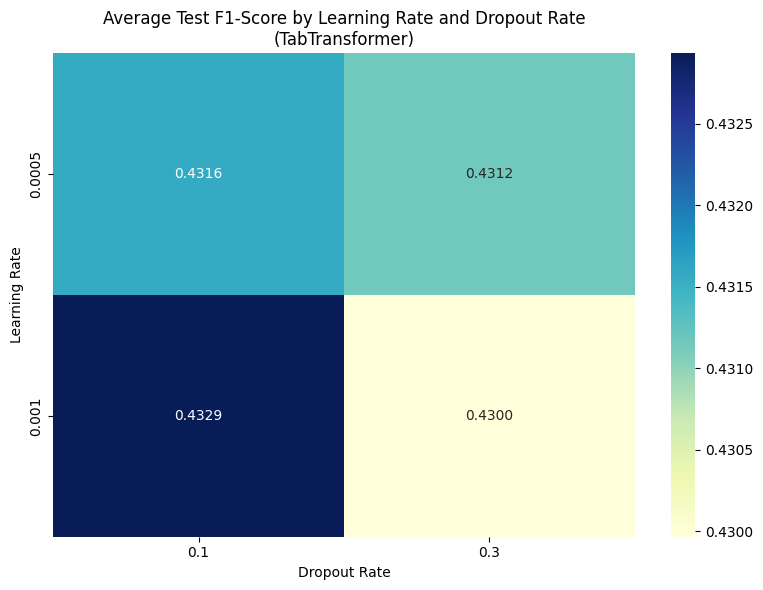

In [13]:
# Pivot the DataFrame for TabTransformer
heatmap_data_tabtransformer = results_df[results_df['Model'] == 'TabTransformer'].pivot_table(
    values='Test F1-Score',
    index='Learning Rate',
    columns='Dropout Rate',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_tabtransformer, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title('Average Test F1-Score by Learning Rate and Dropout Rate\n(TabTransformer)')
plt.xlabel('Dropout Rate')
plt.ylabel('Learning Rate')
plt.tight_layout()
plt.show()

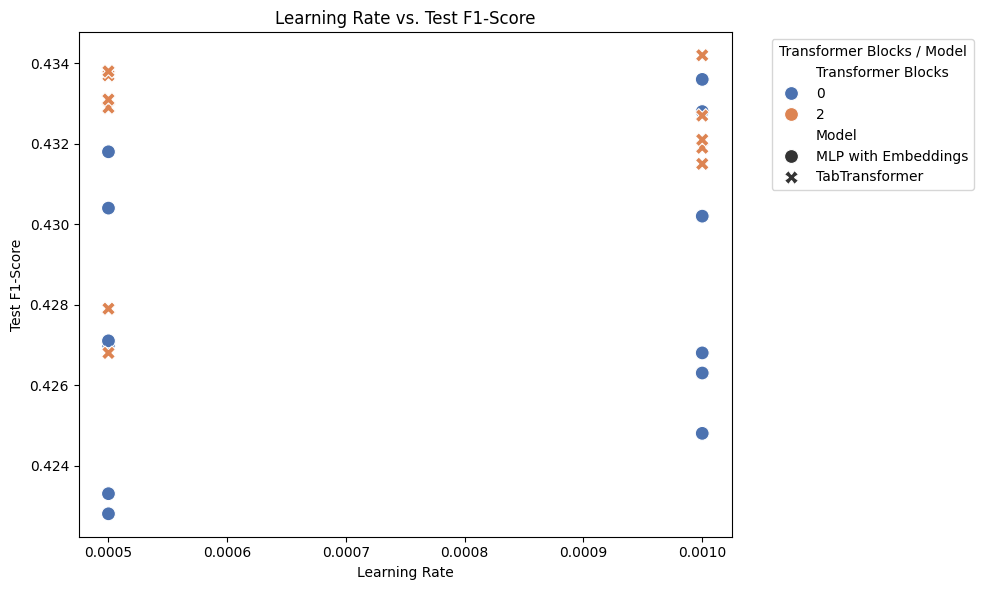

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Learning Rate',
    y='Test F1-Score',
    hue='Transformer Blocks',
    style='Model',
    data=results_df,
    s=100,
    palette='deep'
)
plt.title('Learning Rate vs. Test F1-Score')
plt.xlabel('Learning Rate')
plt.ylabel('Test F1-Score')
plt.legend(title='Transformer Blocks / Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/l3/dmypj9f129703vwfp22qvkf40000gq/T/ipykernel_8972/2116359667.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model')


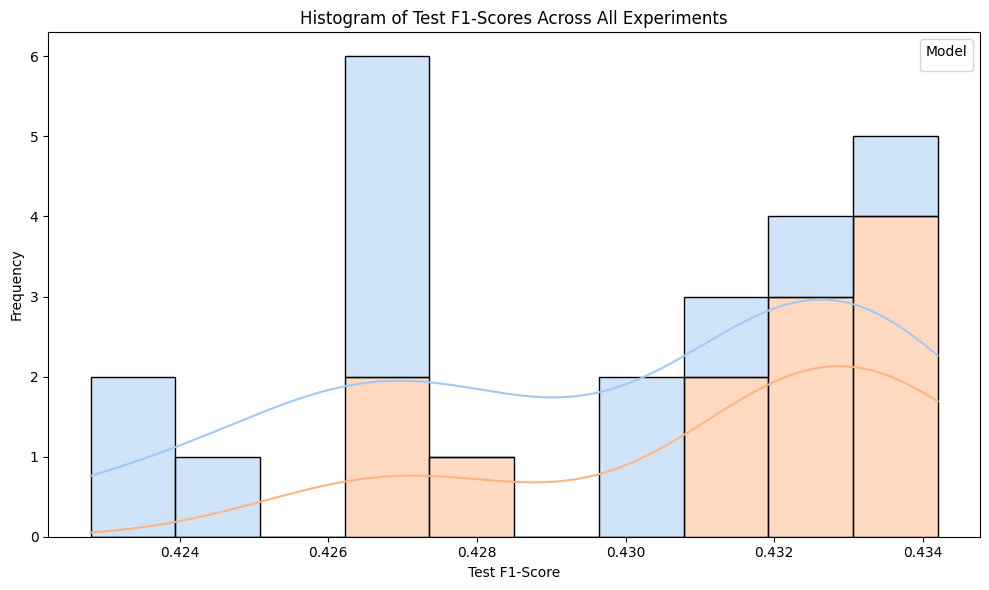

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='Test F1-Score', hue='Model', bins=10, kde=True, multiple='stack', palette='pastel')
plt.title('Histogram of Test F1-Scores Across All Experiments')
plt.xlabel('Test F1-Score')
plt.ylabel('Frequency')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [16]:
# Select the top 3 models based on Test F1-Score for each Model type
top_models_mlp = results_df[results_df['Model'] == 'MLP with Embeddings'].nlargest(3, 'Test F1-Score').reset_index(drop=True)
top_models_tabtransformer = results_df[results_df['Model'] == 'TabTransformer'].nlargest(3, 'Test F1-Score').reset_index(drop=True)

# Combine top models into one DataFrame
top_models = pd.concat([top_models_mlp, top_models_tabtransformer], ignore_index=True)

print("=== Top 3 Models for Each Model Type ===")
display(top_models)

=== Top 3 Models for Each Model Type ===


,Seed,Learning Rate,Dropout Rate,Transformer Blocks,Best Threshold,Test F1-Score,Model
0,1,0.0010,0.1,0,0.6321,0.4336,MLP with Embeddings
1,0,0.0010,0.1,0,0.6550,0.4328,MLP with Embeddings
2,1,0.0005,0.1,0,0.6173,0.4318,MLP with Embeddings
3,2,0.0010,0.1,2,0.6545,0.4342,TabTransformer
4,2,0.0005,0.3,2,0.6225,0.4338,TabTransformer
5,0,0.0005,0.1,2,0.6376,0.4337,TabTransformer


In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# Iterate over each top model to plot ROC and Precision-Recall curves
for idx, row in top_models_extended.iterrows():
    y_true = row['Y_True']
    y_scores = row['Y_Score']
    
    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(12, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model={row["Model"]}, Seed={row["Seed"]}')
    plt.legend(loc='lower right')
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - Model={row["Model"]}, Seed={row["Seed"]}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrix
    y_pred = [1 if score >= row['Best Threshold'] else 0 for score in y_scores]
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Model={row["Model"]}, Seed={row["Seed"]}')
    plt.tight_layout()
    plt.show()

ModuleNotFoundError: No module named 'sklearn'

In [19]:
!pip3 install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 11.7 MB/s eta 0:00:00a 0:00:01


NameError: name 'top_models_extended' is not defined